In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

filepath_status = 'data/status_report.csv'
filepath_flights = 'data/flights.csv'

#DataFrame
status_report = pd.read_csv(filepath_status)
flight_report = pd.read_csv(filepath_flights)

#just making the imported data into date times, filling in desired col
status_report['start_work'] = pd.to_datetime(status_report['start_work'])
status_report['end_work'] = pd.to_datetime(status_report['end_work'])
status_report['start_downtime'] = pd.to_datetime(status_report['start_downtime'])
status_report['end_downtime'] = pd.to_datetime(status_report['end_downtime'])
status_report['total_downtime'] = status_report['end_downtime'] - status_report['start_downtime']
#this is assuming the data has been already been added and is accurate
#also, the data should be sorted by date (after airplane)

flight_report['takeoff_time'] = pd.to_datetime(flight_report['takeoff_time'])
flight_report['land_time'] = pd.to_datetime(flight_report['land_time'])
flight_report['sortie_length'] = flight_report['land_time']-flight_report['takeoff_time']

# print(flight_report)

In [49]:
#reduce to NMC only
nmc_status_report = status_report[status_report.status_code == "NMC"]
#reduce to PMC only
pmc_status_report = status_report[status_report.status_code == "PMC"]

#get rid of repeated jobs for graphing purposes
plot_report_nmc = nmc_status_report.drop_duplicates('start_downtime')
#same for pmc
plot_report_pmc = pmc_status_report.drop_duplicates('start_downtime')
#for consistency
plot_report_flights = flight_report.copy()

# print(plot_report_nmc)
# print(plot_report_pmc)
# print(plot_report_flights)

In [58]:
#get a list of acft
acft_list = plot_report_nmc['acft_ID'].unique()
acft_table = dict()
#make a hash table to find pmc times, nmc times, and flight times by aircraft
for acft in acft_list:
    acft_table[acft] = (plot_report_pmc[plot_report_pmc['acft_ID'] == acft][['start_downtime','end_downtime','total_downtime']],
                plot_report_nmc[plot_report_nmc['acft_ID'] == acft][['start_downtime','end_downtime','total_downtime']],
                plot_report_flights[plot_report_flights['acft_ID'] == acft][['takeoff_time','land_time','sortie_length']])

# print(acft_table)

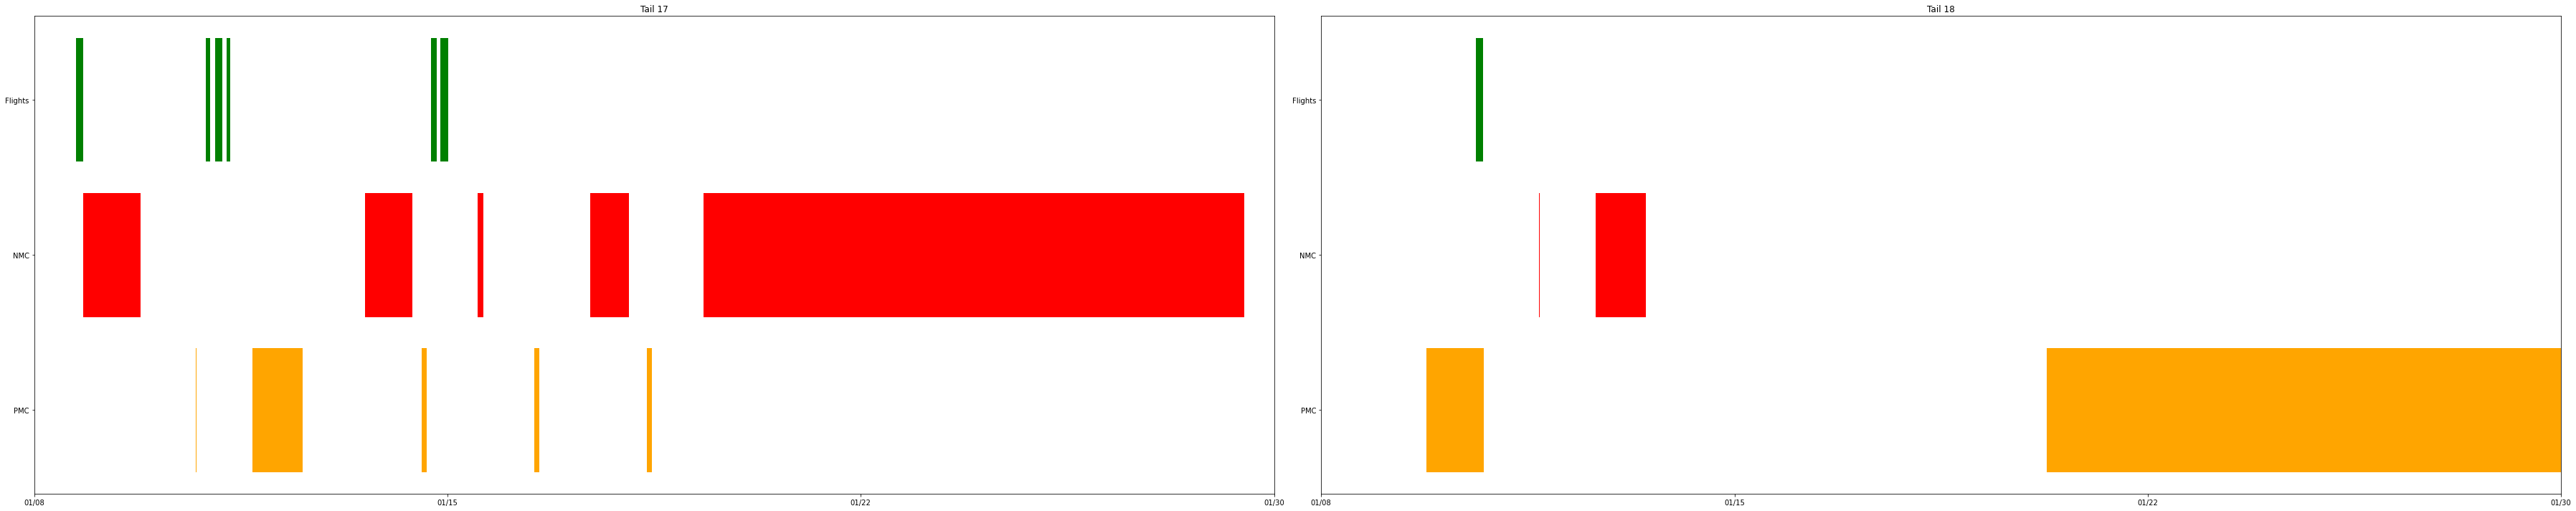

In [51]:

#changeable
start_date = datetime.date(2022,1,8)
end_date = datetime.date(2022,1,30)
date_segments = 4
columns = 2
color_list = ['orange','red','green']

#used for indexing (important!)
pmc,nmc,flt = 0,1,2

#new row every [columns] acft, and [columns]+1 'th acft
num_rows = int(int(len(acft_list/columns)) + len(acft_list)%columns>0)

#create the plot, X rows, X cols
fig, ax = plt.subplots(num_rows,columns, figsize = (50,10))


#note: ax[i] will throw an error if there is only 1 graph
for i,acft in enumerate(acft_list):

    #for pmc bars
    for _,job in acft_table[acft][pmc].iterrows():
        job_start = job[0]
        # job_end = job[1]
        job_length = job[2]
        ax[i].barh('PMC', job_length, left=job_start, color = color_list[pmc])

    #for nmc bars
    for _,job in acft_table[acft][nmc].iterrows():
        job_start = job[0]
        # job_end = job[1]
        job_length = job[2]
        ax[i].barh('NMC', job_length, left=job_start, color = color_list[nmc])

    #for flt bars
    for _,job in acft_table[acft][flt].iterrows():
        job_start = job[0]
        # job_end = job[1]
        job_length = job[2]
        ax[i].barh('Flights', job_length, left=job_start, color = color_list[flt])


    #set acft subplot visual params    
    ax[i].set_xlim(start_date,end_date)
    ax[i].set_xticks( pd.date_range(start_date,  end_date, date_segments).to_list() )
    ax[i].set_xticklabels( pd.date_range(start_date, end_date, date_segments).strftime("%m/%d") )

    ax[i].set_title("Tail " + str(acft))
    
plt.tight_layout()


In [155]:
# the following creates a hash table, search by aircraft to find total 
# number of landings andflighttime between each segment of it being NMC
# assumes that aircraft doesn't fly while NMC

aggregate_landings_before_nmc = dict()
aggregate_flighttime_before_nmc = dict()

for acft in acft_table:
    #init the acft in the hash table
    aggregate_landings_before_nmc[acft] = []
    aggregate_flighttime_before_nmc[acft] = []

    #for keeping track of which flight you are on, assumes data sorted by date!
    start_index = 0

    #a full instance of an aircraft being NMC
    for _,job in acft_table[acft][nmc].iterrows():
        
        #initialize counters
        landings = 0
        flighttime = pd.Timedelta(0)

        #time of the next NMC period
        job_start = job[0]
        # job_end = job[1]
        # job_length = job[2]   

        #exits when no more flights in data OR flight takeoff time is past the NMC start time
        while True:
            try:
                #current flights takeoff time
                flight_takeoff = acft_table[acft][flt].iloc[start_index][0]
                # print(start_index, "-- takeoff: ", flight_takeoff, ', nmc_start: ',job_start)

            except:
                #out of flights, immediately break the loop
                if landings != 0:
                    aggregate_landings_before_nmc[acft].append(landings)
                    aggregate_flighttime_before_nmc[acft].append(flighttime)  
                break

            if flight_takeoff > job_start and start_index == 0:
                #make sure you dont get an unsuable loop if the first flight takeoff time
                #is after the first NMC time, go to the next job, dont increment
                break

            elif flight_takeoff > job_start:
                #NMC has started, proceed to the next NMC job
                #send the accrued landings and flighttimes to the aggregate list
                aggregate_landings_before_nmc[acft].append(landings)
                aggregate_flighttime_before_nmc[acft].append(flighttime)             
                break
                
            #NMC still hasn't happened yet, count the accrued landings and flighttime
            landings += 1
            #add current flights flighttime
            flighttime += acft_table[acft][flt].iloc[start_index][2]
            start_index += 1
            
            # print('landings: ',landings)
            # print('flighttime: ',flighttime)
        
        if landings != 0:
            print("END: totals:  ",aggregate_flighttime_before_nmc[acft],", ",aggregate_landings_before_nmc[acft])
            print("\n NEXT NMC \n")
        
    #convert datetime to integer (hours)
    aggregate_flighttime_before_nmc[acft] = [date.seconds/60/60 for date in aggregate_flighttime_before_nmc[acft]]
    
        


END: totals:   [Timedelta('0 days 03:01:00')] ,  [1]

 NEXT NMC 

END: totals:   [Timedelta('0 days 03:01:00'), Timedelta('0 days 06:29:00')] ,  [1, 3]

 NEXT NMC 

END: totals:   [Timedelta('0 days 03:01:00'), Timedelta('0 days 06:29:00'), Timedelta('0 days 05:48:00')] ,  [1, 3, 2]

 NEXT NMC 

END: totals:   [Timedelta('0 days 03:01:00')] ,  [1]

 NEXT NMC 

{17: [3.0166666666666666, 6.483333333333333, 5.8], 18: [3.0166666666666666]}


In [146]:
from scipy.stats import norm

In [156]:
#this will get mean and stddev, same format, hash table that has aircraft as search term, then (mean,stddev) tuple

normal_values_landings = dict()
normal_values_flighttime = dict()

for acft in acft_list:
    normal_mean = np.mean(aggregate_landings_before_nmc[acft])
    normal_stdev = np.std(aggregate_landings_before_nmc[acft])
    normal_values_landings[acft] = (normal_mean,normal_stdev)

    normal_mean = np.mean(aggregate_flighttime_before_nmc[acft])
    normal_stdev = np.std(aggregate_flighttime_before_nmc[acft])
    normal_values_flighttime[acft] = (normal_mean,normal_stdev)

print(normal_values_landings)
print(normal_values_flighttime)

{17: (2.0, 0.816496580927726), 18: (1.0, 0.0)}
{17: (5.1000000000000005, 1.49932083389879), 18: (3.0166666666666666, 0.0)}


C:\Users\jonfr\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


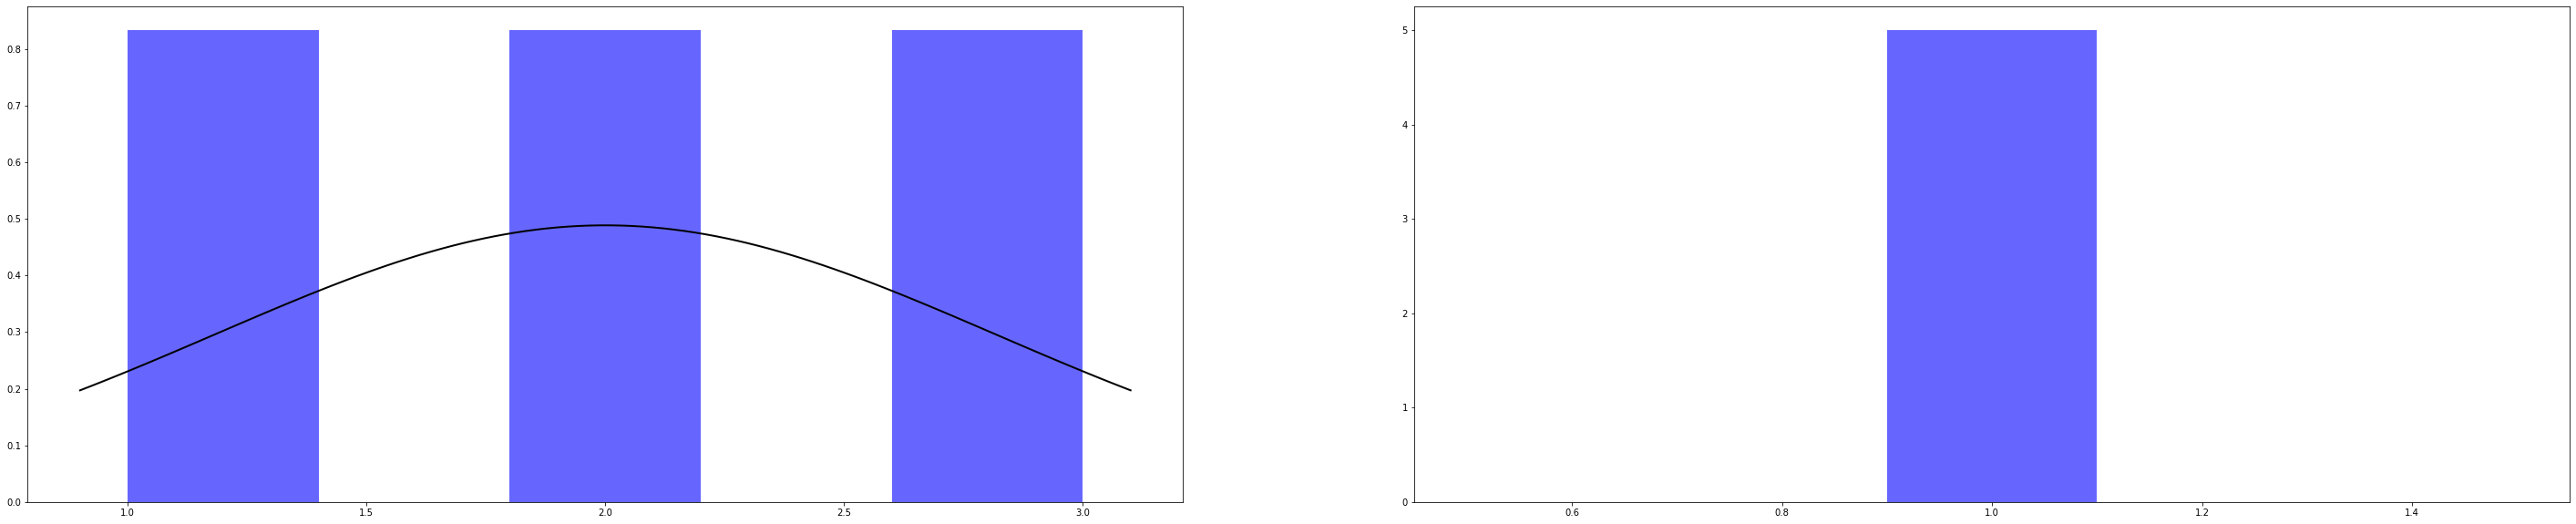

In [157]:
columns = 2

num_rows = int(int(len(acft_list/columns)) + len(acft_list)%columns>0)

#create the plot, X rows, X cols
fig, ax = plt.subplots(num_rows,columns, figsize = (50,10))

for i,acft in enumerate(acft_list):

    #range from 0 to max landings
    data = aggregate_landings_before_nmc[acft]
    # x_axis = np.arange(0,max(aggregate_landings_before_nmc[acft]))
    #scatter plot of all landings
    ax[i].hist(data, bins = 5, density = True, alpha = 0.6, color = 'b')
    # ax[i].scatter(x_axis, aggregate_landings_before_nmc[acft])
    #mean
    m = normal_values_landings[acft][0]
    #stddev
    sd = normal_values_landings[acft][1]
    #normal distribution of landings
    # ax[i].plot(x_axis, norm.pdf(x_axis, m,sd))
    
    mu, std = norm.fit(data)
    xmin, xmax = ax[i].get_xlim()
    x = np.linspace(xmin,xmax,100)
    p = norm.pdf(x,mu,std)
    ax[i].plot(x,p,'k',linewidth = 2)


# print(aggregate_landings_before_nmc)

C:\Users\jonfr\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


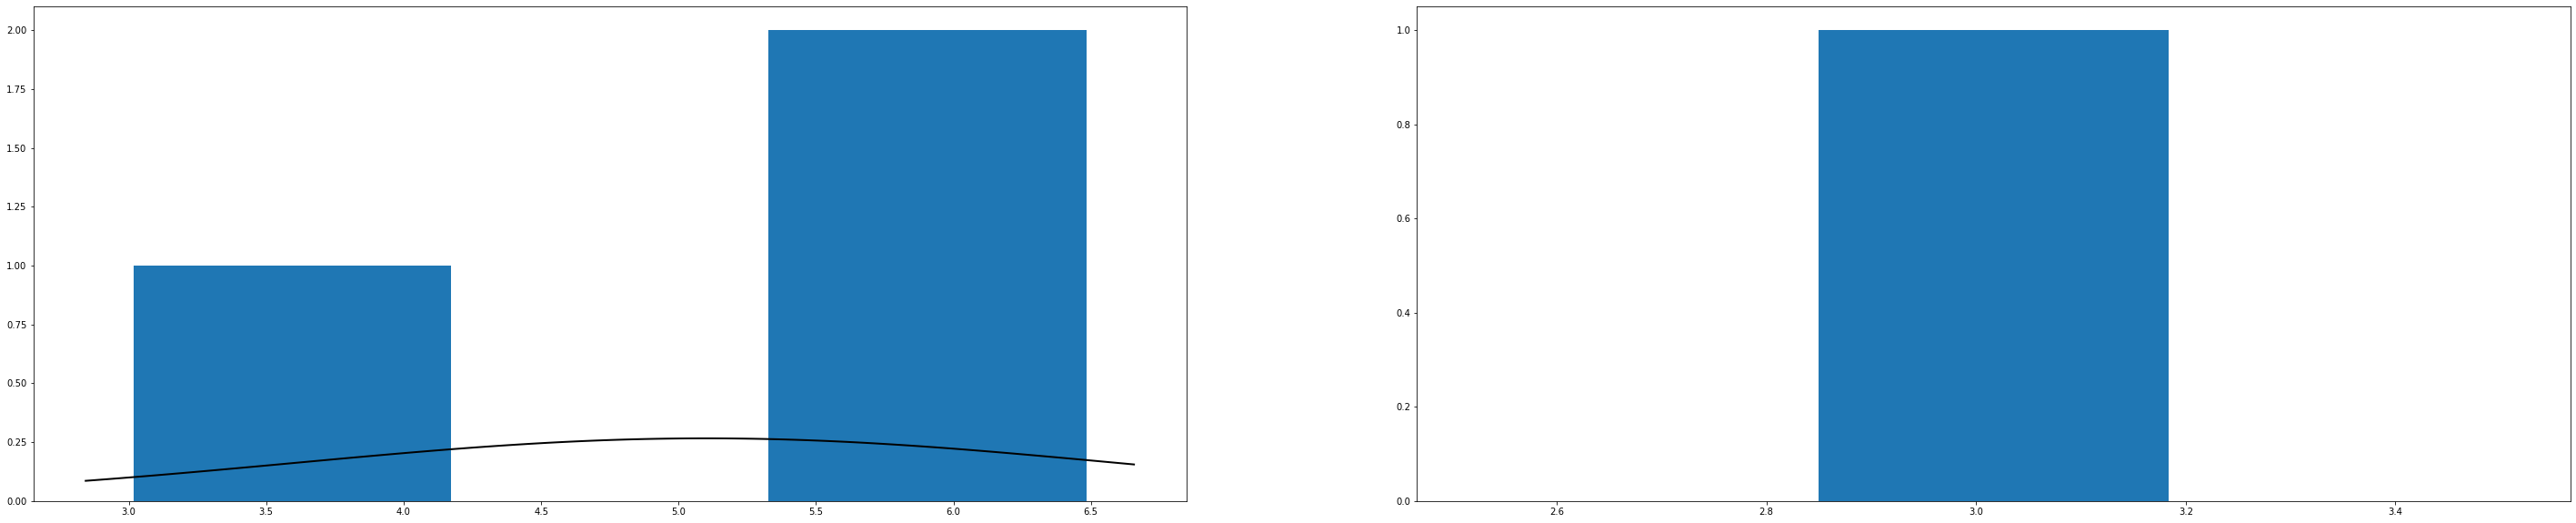

In [159]:
columns = 2

num_rows = int(int(len(acft_list/columns)) + len(acft_list)%columns>0)

#create the plot, X rows, X cols
fig, ax = plt.subplots(num_rows,columns, figsize = (50,10))

for i,acft in enumerate(acft_list):

    #integer, hours
    data = aggregate_flighttime_before_nmc[acft]
    # print(data)

    #range from 0 to max landings
    x_axis = np.arange(0,10)
    #scatter plot of all landings
    ax[i].hist(data,bins = 3)
    #mean
    m = normal_values_flighttime[acft][0]
    #stddev
    sd = normal_values_flighttime[acft][1]

    #normal distribution of flighttime
    mu, std = norm.fit(data)
    xmin, xmax = ax[i].get_xlim()
    x = np.linspace(xmin,xmax,100)
    p = norm.pdf(x,mu,std)
    ax[i].plot(x,p,'k',linewidth = 2)



# print(aggregate_flighttime_before_nmc)